In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier

import glob as gl
import os

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import time

In [2]:
path = "src/results"

""" datetime = "/2011-03-24_15"
df = pd.read_csv(path + datetime + '.csv')  """


dfs = []

for file in gl.glob(path + '/20*.csv'):
    dfs.append(pd.read_csv(file))

df = pd.concat(dfs, ignore_index=True)
#df.count() #cada csv tiene 160920 filas

## Label Encoder

In [3]:
modelo = df.iloc[:, 8].values 
modelo = LabelEncoder().fit_transform(modelo) #codificación del modelo

In [4]:
df = df.drop(df.columns[8], axis=1) #se elimina la antigua con los strings del modelo
df['modelo'] = modelo #se añade la nueva codificada al final

X = df.iloc[:, 1:] 
X = X.drop(['datetime', 'timestamp', 'load', 'DC Array Output (W)' , 'Pavg', 'dif'], axis=1)
y = df.iloc[:, 0].values #valores de overflow

X.columns

Index(['cap', 'dist', 'origen_id', 'dest_id', 'len_origen_tag', 'len_dest_tag',
       'criterion', 'degree', 'total_balance', 'abs_flux', 'h',
       'Beam Irradiance (W/m2)', 'Diffuse Irradiance (W/m2)',
       'Ambient Temperature (C)', 'Plane of Array Irradiance (W/m2)',
       'Cell Temperature (C)', 'modelo'],
      dtype='object')

## Split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

sc = StandardScaler() #escalado de datos
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## ANN

In [6]:
def create_model():
    model = keras.Sequential([
        
        #Adding the input layer and the first hidden layer
        #se prueba con 6, los valores se obtienen probando o con alguna técnica como k Fold Cross Validation
        keras.layers.Dense(5, input_shape=(X.shape[1],), activation='relu'), #nº de entradas
        
        #Adding the second hidden layer
        #mismo valor que arriba
        keras.layers.Dense(5, activation='relu'),
        
        #Adding the output layer -> 1 salida: 0 o 1
        #*si no es salida binaria, se indica el número de posibles salidas y activation='softmax'
        keras.layers.Dense(1, activation='sigmoid')
    ]) 

    model.summary() #resumen de la estructura de la red neuronal
    #los parámetros son los pesos

    return model

#model = KerasClassifier(build_fn=create_model)
model = create_model()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 90        
                                                                 
 dense_1 (Dense)             (None, 5)                 30        
                                                                 
 dense_2 (Dense)             (None, 1)                 6         
                                                                 
Total params: 126 (504.00 Byte)
Trainable params: 126 (504.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
#binary_crossentropy -> clasificación binaria (si/no)
#*si no es salida binaria, se aplica categorical_crossentropy o sparse_categorical_crossentropy

inicl = time.time()
model.compile(optimizer = 'sgd', loss = 'binary_crossentropy', metrics = ['accuracy'])
#History = model.fit(X_train, y_train, batch_size = 50, epochs = 8) #loss: 0.0686 - accuracy: 0.9789
#History = model.fit(X_train, y_train, epochs = 100)
History = model.fit(X_train, y_train, epochs=100, verbose=1, 
                            callbacks=[keras.callbacks.EarlyStopping(monitor='loss', patience=10, verbose=1, min_delta=0.00001)])
fincl = time.time()

#94 min
# Epoch 55/55
#48276/48276 [==============================] - 104s 2ms/step - loss: 0.0501 - accuracy: 0.9829
#174 min
#Epoch 100/100
#48276/48276 [==============================] - 104s 2ms/step - loss: 0.0441 - accuracy: 0.9848


Epoch 1/100


48276/48276 [==============================] - 148s 3ms/step - loss: 0.0878 - accuracy: 0.9767
Epoch 2/100
48276/48276 [==============================] - 113s 2ms/step - loss: 0.0739 - accuracy: 0.9781
Epoch 3/100
48276/48276 [==============================] - 111s 2ms/step - loss: 0.0722 - accuracy: 0.9783
Epoch 4/100
48276/48276 [==============================] - 109s 2ms/step - loss: 0.0718 - accuracy: 0.9783
Epoch 5/100
48276/48276 [==============================] - 106s 2ms/step - loss: 0.0715 - accuracy: 0.9784
Epoch 6/100
48276/48276 [==============================] - 104s 2ms/step - loss: 0.0713 - accuracy: 0.9785
Epoch 7/100
48276/48276 [==============================] - 100s 2ms/step - loss: 0.0712 - accuracy: 0.9785
Epoch 8/100
48276/48276 [==============================] - 105s 2ms/step - loss: 0.0710 - accuracy: 0.9785
Epoch 9/100
48276/48276 [==============================] - 102s 2ms/step - loss: 0.0709 - accuracy: 0.9785
Epoch 10/100
48276/48276 [========

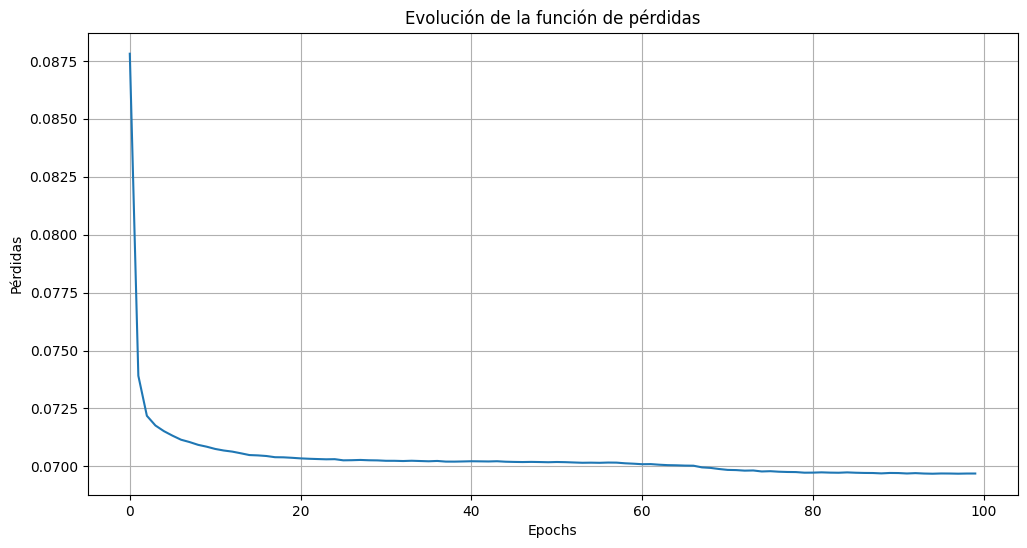

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(History.history['loss'])
plt.title('Evolución de la función de pérdidas')
plt.ylabel('Pérdidas')
plt.xlabel('Epochs')
plt.grid(True)
plt.show()

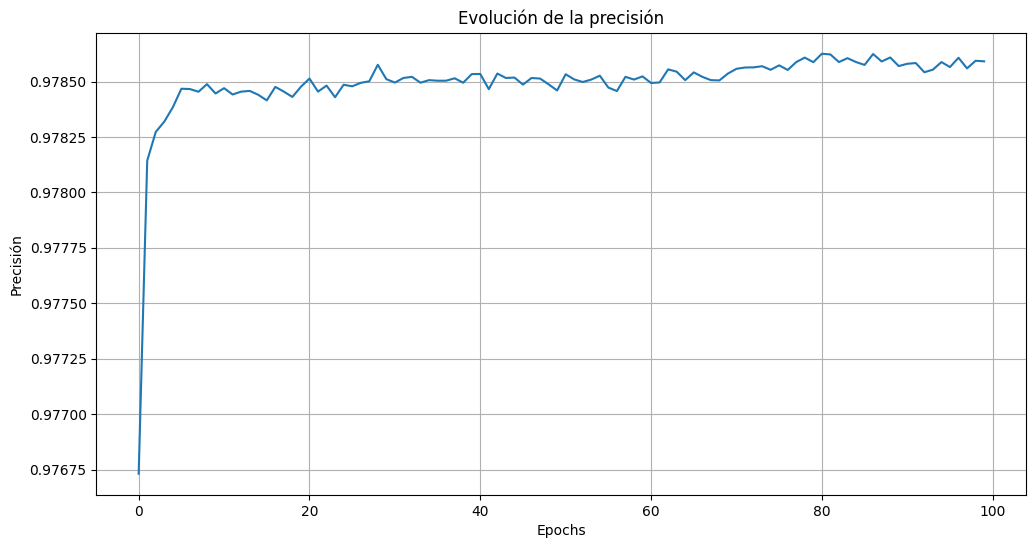

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(History.history['accuracy'])
plt.title('Evolución de la precisión')
plt.ylabel('Precisión')
plt.xlabel('Epochs')
plt.grid(True)
plt.show()

## Evaluación

In [10]:
#se obtienen las pérdidas y la precisión del modelo
test_loss, test_accuracy = model.evaluate(X_test, y_test)
#si la precisión obtenida aquí es mucho menor que la de las épocas, se está sobreentrenando el modelo

#(7,7,1) 50 epochs, 20 epochs
#loss: 0.0685 - accuracy: 0.9789 
#loss: 0.0689 - accuracy: 0.9786 

#(5,5)
#loss: 0.0690 - accuracy: 0.9785

12069/12069 [==============================] - 21s 1ms/step - loss: 0.0689 - accuracy: 0.9787


### Matriz de confusión

In [11]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

#(7,7,1) 50 epochs, 20 epochs
#[[376455    689] [  7515   1549]] 0.9787575606926837
#[[376312    837] [  7318   1741]] 0.9789 

#(5,5)
#[[376674    470] [  7842   1222]] 0.9784779186345182 -> 100 iteraciones

12069/12069 [==============================] - 15s 1ms/step
[[376499    645]
 [  7566   1498]]


0.9787394357444693

## Grid Search

In [ ]:
parameters = {
    'hidden_layer_sizes': [(5,5,1), (6,6,1), (7,7,1), (8,8,1)],
    'activation': ['sigmoid', 'tanh','relu'],
}

processors = 32
cv = 5 
combos = 1

for i in parameters:
    for j in i.values():
        combos *= len(j)

num_models = combos * cv / processors 
seconds = num_models * (fincl-inicl)
minutes = seconds / 60
hours = minutes / 60

print("{:.6f}".format(hours), "| {:.6f}".format(minutes), "| {:.6f}".format(seconds)) #81.85seg (7,7,1)

In [ ]:
inigs = time.time()

model_gs = KerasClassifier(build_fn=create_model)

grid_search = GridSearchCV(estimator = model_gs,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           n_jobs = 1)

grid_search.fit(X_train, y_train)

fings = time.time()

best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)
print("Tiempo ejecución grid search: " + str(fings-inigs))


########
#Best Accuracy: 98.20 %
#Best Parameters: {'activation': 'tanh', 'hidden_layer_sizes': (7, 7, 1), 'learning_rate': 'constant', 'solver': 'adam'} """